In [ ]:
!nvidia-smi

Wed Dec  9 19:25:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install "nltk==3.5" # necessário para usar o meteor

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import random

from keras import backend as K 

# preprocessamnento e tokenização
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Camadas do modelo
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

# Model, callback e otimizador
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
# from nltk.translate.nist_score import sentence_nist, corpus_nist
from nltk.translate.meteor_score import meteor_score

In [ ]:
nltk.download('wordnet') # necessário para usar o meteor

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from tqdm.notebook import tqdm # necessário para mostrar a barra de progresso

In [ ]:
seed = 0
np.random.seed(seed)
random.seed(seed)

In [ ]:
SOS = '<start>'
EOS = '<end>'

# path = '../data/b2w-10k.csv'
# sep = ','

# path = "https://raw.githubusercontent.com/feperessim/NLPortugues/master/Semana%2006/data/b2w-10k.csv"
# sep = ','

# path = '../data/B2W-Reviews01.csv
# sep = ';'

path = 'https://raw.githubusercontent.com/b2wdigital/b2w-reviews01/master/B2W-Reviews01.csv'
sep = ';'

sns.set_theme()

In [ ]:
contraction_mapping = {'ñ' : 'não', 'n' : 'não', 'naum' : 'não', 's':'sim', 'vc' : 
                       'você', 'tbm' : 'também', 'tbn':'também', 'tb' : 'também', 
                       'kd' : 'cade', 'kade' : 'cade', 'kual' : 'qual', 'mt' : 'muito',
                       'msm' : 'mesmo', 'axo' : 'acho', 'q' : 'que', 'hj' : 'hoje', 
                       'blz' : 'beleza', 'ctz' : 'certeza', 'fikdik' : 'fica a dica',
                       'glr' : 'galera', 'msg' : 'mensagem', 'pfv' : 'por favor', 
                       'plmdds' : 'pelo amor de deus', 'pq' : 'porque', 'vdd' : 'verdade', 
                       'bosta' : 'ruim', 'merda' : 'ruim', 'abç' : 'abraço', 'bj' : 'beijo',
                       'bjs' : 'beijos', 't+' : 'até mais', 'eh' : 'é', 'aki' : 'aqui', 'ruin':'ruim'}

In [ ]:
def preprocess_sentence(sentence):
    '''
    Normalize preprocess a sequence of words
    in a sentence. 
    This function does the following:
    
    1 - Convert everything to lowercase;
        removes trailing and leading spaces
    
    2 - remove digits
    
    3 - Creates a space between a word and the
        punctuation following it;
        also, it replaces repetitions of
        punctuations by a single instance;
    
    4 - replaces informal contractions by 
        its equivalent formal word.
        
    5 - # replaces special symbols
        
    Add a start and end token to each sentence.
    
    Args:
        sentence - a human readable string
    returns:
        a string of preprocessed text
    '''
    # Convert to lower case; remove digits; 
    # and replace many dots by a single one
    # keep only words with length at most WORD_MAX_LEN
    sentence = sentence.lower().strip()
    sentence = sentence.translate(str.maketrans('', '', string.digits))

    # replace multiple punctuation by a single one
    # Reference: https://stackoverflow.com/questions/35041672/regex-replace-multiple-punctuation-in-python
    sentence = re.sub(r'[\?\.\!]+(?=[\?\.\!])', "", sentence)
    
    # creating a space between a word and the punctuation following it
    # eg: "ele é um menino." => "ele é um menino ."
    # Reference: https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # replace contractions by the real word e.g vc - você
    sentence = ' '.join([contraction_mapping[word]
                         if word in contraction_mapping
                         else word for word in sentence.split(' ')])
    
    # replace special symbols
    sentence = re.sub('[!*)@#%(&$_^~]', '', sentence)
    
    sentence = sentence.strip()
    
    return sentence

In [ ]:
def tokenize(sentences, tokenizer=None, maxlen=50):
    '''
    Encodes a string to an array of integers

    Args:
        lang (list): list of human-readable strings to encode  
    Returns:
        numpy.ndarray: tensor with tokenized version of the input string
        Tokenizer: Keras tokenizer instance
    '''
    # Keras Tokenizer
    if tokenizer is None:
        lang_tokenizer = Tokenizer(filters='')
        lang_tokenizer.fit_on_texts(sentences)
    else:
        lang_tokenizer = tokenizer
    
    tensor = lang_tokenizer.texts_to_sequences(sentences)
    tensor = pad_sequences(tensor, maxlen=maxlen, padding='post')
    
    return tensor, lang_tokenizer

In [ ]:
def detokenize(integers, tokenizer):
    '''
    Decodes an array of integers to a human readable string

    Args:
        Args:
        integers (list): list of strings to decode
        tokenizer: Keras tokenizer instance
    Returns:
        (list): list of human-readable strings  
    ''' 
    return [tokenizer.index_word[integer] for integer in integers if integer != 0]

In [ ]:
def create_dataset(x, y):
    '''
    Apply the transformations in
    the function preprocess_sentence
    to every line of text in x and y
    Args:
        x, y - list of human readable strings
    returns:
        list of human readable strings preprocessed
    '''
    return ([preprocess_sentence(sentence) for sentence in x],
            [preprocess_sentence(sentence) for sentence in y])

In [ ]:
def load_dataset_and_preprocess(path='../data/b2w-10k.csv', sep=','):
    '''
    creating cleaned input, output pairs of
    length at most SEQUENCE_MAXLEN
    Args:
        path (string) : full path to the dataset
    returns:
        (list of strings, list of strings): text and title 
        lists of strings
    '''
    usecols = ["review_text", "review_title"]
    
    dataset = pd.read_csv(path, usecols=usecols, sep=sep, error_bad_lines=False)
    
    # dropping duplicates and dropping na
    dataset.drop_duplicates(subset=['review_text'], inplace=True)
    dataset.dropna(axis=0,inplace=True)
    
    # dropping sentences with length <= 2
    dataset = dataset[dataset['review_text'].apply(len) > 2]
    dataset = dataset[dataset['review_title'].apply(len) > 2]

    text, title = create_dataset(dataset["review_text"].values, dataset["review_title"].values)
    
    return text, title

In [ ]:
def insert_start_end_tokens(sentences):
    '''
    Insert start and end tokens
    to every sentence of sentences
    Args:
        sentences - list of human readable strings
    returns:
        list of human readable strings with SOS and EOS
        between the text
    '''
    return [SOS + ' ' + sentence + ' ' + EOS for sentence in sentences]

In [ ]:
def compute_bleu(text, title, text_maxlen, seq2title, decode_sequence):
    '''
    Args:
        text (tensor) : array of word indexes
        title (tensor) : array of word indexes
        text_maxlen (int) : max length of a sentence
        seq2title (function) : converts index to word
        decode_sequence (function) : predicts the review title
    returns:
        scores (tensor) : bleu scores for each sentence of text tensor
    '''
    scores = []
    with tqdm(total=len(title)) as pbar:
      for index in range(len(title)):
          reference = seq2title(title[index]).strip()
          candidate = decode_sequence(text[index].reshape(1, text_maxlen)).strip()
          score = sentence_bleu([reference], candidate)
          scores.append(score)
          pbar.update(1)
    return scores

In [ ]:
def compute_meteor(text, title, text_maxlen, seq2title, decode_sequence):
    '''
    Args:
        text (tensor) : array of word indexes
        title (tensor) : array of word indexes
        text_maxlen (int) : max length of a sentence
        seq2title (function) : converts index to word
        decode_sequence (function) : predicts the review title
    returns:
        scores (tensor) : meteor scores for each sentence of text tensor
    '''
    scores = []
    with tqdm(total=len(title)) as pbar:
      for index in range(len(title)):
          reference = seq2title(title[index]).strip()
          candidate = decode_sequence(text[index].reshape(1, text_maxlen)).strip()
          if reference != '' and candidate != '':
              score = meteor_score([reference], candidate)
              scores.append(score)
          pbar.update(1)
    return scores

In [ ]:
def translate(sentences, decode_sequence, tokenizer, text_maxlen):
    '''
    Predicts a title review for a given sentence
    Args:
        sentences (list:str) : list with sentences to translate
        decode_sequence (function) : predicts the review title
        tokenizer (Tokenizer) : text tokenizer 
        text_maxlen : max length of a text sentence
    returns:
        decoded_sentence (list:str) : list of human readable strings 
    '''
    result = [preprocess_sentence(sentence) for sentence in sentences]
    result, _ = tokenize(result, tokenizer, text_maxlen)
    decoded_sentences = []
    
    for sequence in result:
        s = decode_sequence(sequence.reshape(1, text_maxlen))
        decoded_sentences.append(s)
    return decoded_sentences

In [ ]:
def plot_dist_sentences(text, title):
    '''
    Plots the sentences distributions
    Args:
        text, title - list preprocessed strings
    returns:
        list of human readable strings preprocessed
    '''
    text_word_count = []
    title_word_count = []

    # populate the lists with sentence lengths
    for i in text:
          text_word_count.append(len(i.split()))

    for i in title:
          title_word_count.append(len(i.split()))

    fig = plt.figure(figsize = (15,5))

    ax = fig.gca()

    length_df = pd.DataFrame({'Text review':text_word_count, 'Title review':title_word_count})
    length_df.hist(bins = [i for i in range(0, 105, 5)], ax=ax)

    # set title and axis labels
    plt.suptitle('Distribuição da quantidade de palavras por sentença', x=0.5, y=1.05, ha='center', fontsize='xx-large')
    fig.text(0.5, 0.04, 'Quantidade de palavras por sentença', ha='center')
    fig.text(0.04, 0.5, 'Frequência', va='center', rotation='vertical')

    plt.show()

In [ ]:
def plot_loss(history, filename='', save=False):
    '''
    Input:
        history (dict) : keras history instance
        filename (string) : filename to save
        save (boolean) : to choose save the plot
    Output:
       None
    '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    nb_epochs = len(loss)
  
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 14}
    title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
                  'verticalalignment':'bottom'} 

    plt.figure(figsize=(20,10))
    plt.xlabel(str(nb_epochs) + ' Epochs', **font)
    plt.ylabel('Loss', **font)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss', **title_font)
    plt.legend()
    if save:
        plt.savefig('../rel/figuras/' + filename + 'loss.png')
    plt.show()

In [ ]:
def plot_acc(history, filename='', save=False):
    '''
    Input:
        history (dict) : keras history instance
        filename (string) : filename to save
        save (boolean) : to choose save the plot
    Output:
       None
    '''
    accuracy = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(accuracy) + 1)
    nb_epochs = len(accuracy)
  
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 14}
    title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
                  'verticalalignment':'bottom'} 

    plt.figure(figsize=(20,10))
    plt.xlabel(str(nb_epochs) + ' Epochs', **font)
    plt.ylabel('Accuracy', **font)
    plt.plot(epochs, accuracy, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc', **title_font)
    plt.legend()
    if save:
        plt.savefig('../rel/figuras/' + filename + 'acc.png')
    plt.show()

In [ ]:
# import os
# Classe de atenção retirada de: https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py

class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# Carregar e preprocessar o dataset

Aqui o dataset é carregado e preprocessado.

In [ ]:
text_train, title_train = load_dataset_and_preprocess(path, sep)

# Distribuição do texto

A distribuição é analisada para se determinar o tamanho máximo das sentenças.

Obs: Espaços não são contabilizados

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


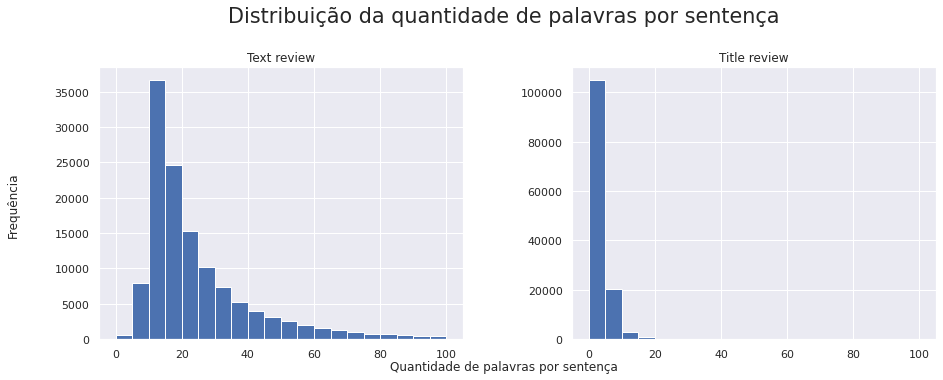

In [ ]:
plot_dist_sentences(text_train, title_train)

In [ ]:
TEXT_MAXLEN = 64
TITLE_MAXLEN = 15

# Adicionar SOS e EOS nas strings do title review

Agora adicionamos SOS e EOS nas strings do title review. 

In [ ]:
title_train = insert_start_end_tokens(title_train)

# Split e tokenização

Separamos os conjuntos em conjuntos de treino, validação e de testes com proporções 80%, 10%, 10%.
Por último tokenizamos e fazemos o preenchimento com pad.

In [ ]:
text_train, text_val, title_train, title_val = train_test_split(text_train, title_train, test_size=0.2,random_state=seed, shuffle=True)
text_val, text_test, title_val, title_test = train_test_split(text_val, title_val, test_size=0.5,random_state=seed,shuffle=True)

In [ ]:
text_train, text_tokenizer = tokenize(text_train, tokenizer=None, maxlen=TEXT_MAXLEN)
text_val, _ = tokenize(text_val, tokenizer=text_tokenizer, maxlen=TEXT_MAXLEN)
text_test, _ = tokenize(text_test, tokenizer=text_tokenizer, maxlen=TEXT_MAXLEN)

title_train, title_tokenizer = tokenize(title_train, tokenizer=None, maxlen=TITLE_MAXLEN)
title_val, _ = tokenize(title_val, tokenizer=title_tokenizer, maxlen=TITLE_MAXLEN)
title_test, _ = tokenize(title_test, tokenizer=title_tokenizer, maxlen=TITLE_MAXLEN)

In [ ]:
title_idx2word = title_tokenizer.index_word 
text_idx2word = text_tokenizer.index_word 
title_word2idx = title_tokenizer.word_index

In [ ]:
print('Shapes dos conjuntos após realizar todas as etapas necessárias')
print()
print('TEXT')
print('=======================')
print('Train:', text_train.shape)
print('Val:  ', text_val.shape)
print('Test: ', text_test.shape)
print('=======================')
print()
print('TITLE:')
print('=======================')
print('Train: ', title_train.shape)
print('Val:   ', title_val.shape)
print('Test   ', title_test.shape)
print('=======================')

Shapes dos conjuntos após realizar todas as etapas necessárias

TEXT
Train: (103340, 64)
Val:   (12917, 64)
Test:  (12918, 64)

TITLE:
Train:  (103340, 15)
Val:    (12917, 15)
Test    (12918, 15)


# Tamanho do vocabulário

Aqui definimos os tamanhos dos vocabulários do <i>text review</i> e <i>title review</i>

In [ ]:
TEXT_VOC_SIZE = len(text_tokenizer.word_index) + 1 # + 1 para oov
TITLE_VOC_SIZE = len(title_tokenizer.word_index) +  1

In [ ]:
print('Tamanho dos vocabulários - Vocabulários restritos ao conjunto de treino apenas')
print()
print('=======================')
print('Text:', TEXT_VOC_SIZE, 'palavras')
print('=======================')
print()
print('=======================')
print('Title:', TITLE_VOC_SIZE, 'palavras')
print('=======================')


Tamanho dos vocabulários - Vocabulários restritos ao conjunto de treino apenas

Text: 49145 palavras

Title: 13622 palavras


# Construção do modelo BiLSTM com atenção

In [ ]:
K.clear_session() 
EMBEEDING_DIM = 128

# Encoder 
encoder_inputs = Input(shape=(TEXT_MAXLEN,)) 
enc_emb = Embedding(TEXT_VOC_SIZE, EMBEEDING_DIM,trainable=True)(encoder_inputs) 

forward_layer = LSTM(EMBEEDING_DIM//2, return_state=True, return_sequences=True) 
backward_layer = LSTM(EMBEEDING_DIM//2, return_state=True, return_sequences=True, go_backwards=True)

encoder_bilstm3 = Bidirectional(forward_layer, backward_layer=backward_layer)
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm3(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(TITLE_VOC_SIZE, EMBEEDING_DIM,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(EMBEEDING_DIM, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer =  AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(TITLE_VOC_SIZE, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 128)      6290560     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 64, 128), (N 98816       embedding[0][0]                  
_______________________________________________________________________________________

# Treinamento do Modelo

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
EPOCHS = 25
BATCH_SIZE = 256

In [ ]:
history=model.fit(
    [text_train, title_train[:,:-1]], 
    title_train.reshape(title_train.shape[0], title_train.shape[1], 1)[:,1:],
    epochs=EPOCHS, 
    callbacks=[es], 
    batch_size=BATCH_SIZE, 
    validation_data=([text_val, title_val[:,:-1]], 
                     title_val.reshape(title_val.shape[0], title_val.shape[1], 1)[:,1:]))

Epoch 1/25
404/404 [==============================] - 99s 246ms/step - loss: 1.8312 - accuracy: 0.7613 - val_loss: 1.2280 - val_accuracy: 0.7966
Epoch 2/25
404/404 [==============================] - 97s 240ms/step - loss: 1.2220 - accuracy: 0.8008 - val_loss: 1.1159 - val_accuracy: 0.8103
Epoch 3/25
404/404 [==============================] - 98s 243ms/step - loss: 1.1241 - accuracy: 0.8106 - val_loss: 1.0564 - val_accuracy: 0.8151
Epoch 4/25
404/404 [==============================] - 98s 242ms/step - loss: 1.0617 - accuracy: 0.8157 - val_loss: 1.0110 - val_accuracy: 0.8202
Epoch 5/25
404/404 [==============================] - 97s 241ms/step - loss: 1.0121 - accuracy: 0.8203 - val_loss: 0.9803 - val_accuracy: 0.8232
Epoch 6/25
404/404 [==============================] - 98s 241ms/step - loss: 0.9710 - accuracy: 0.8241 - val_loss: 0.9608 - val_accuracy: 0.8252
Epoch 7/25
404/404 [==============================] - 98s 242ms/step - loss: 0.9350 - accuracy: 0.8271 - val_loss: 0.9452 - val_ac

# Avaliação conjunto de testes

In [ ]:
model.evaluate([text_test, title_test[:,:-1]],
               title_test.reshape(title_test.shape[0],
                                 title_test.shape[1], 1)[:,1:])

404/404 [==============================] - 6s 15ms/step - loss: 0.9481 - accuracy: 0.8250


[0.9480562806129456, 0.8250281810760498]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


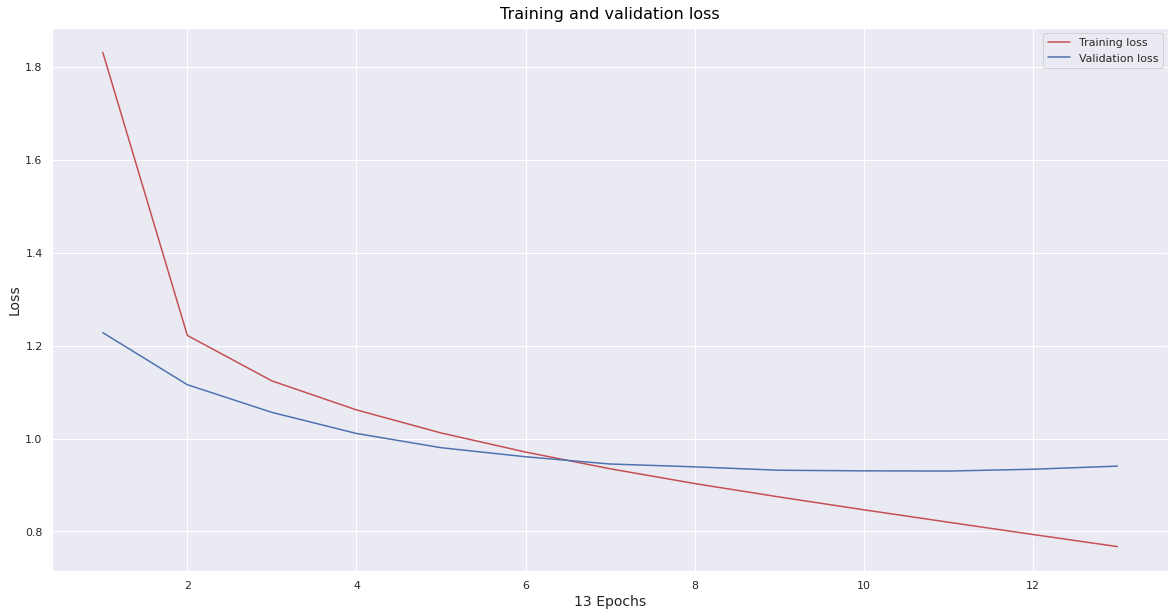

In [ ]:
plot_loss(history, filename='', save=False)

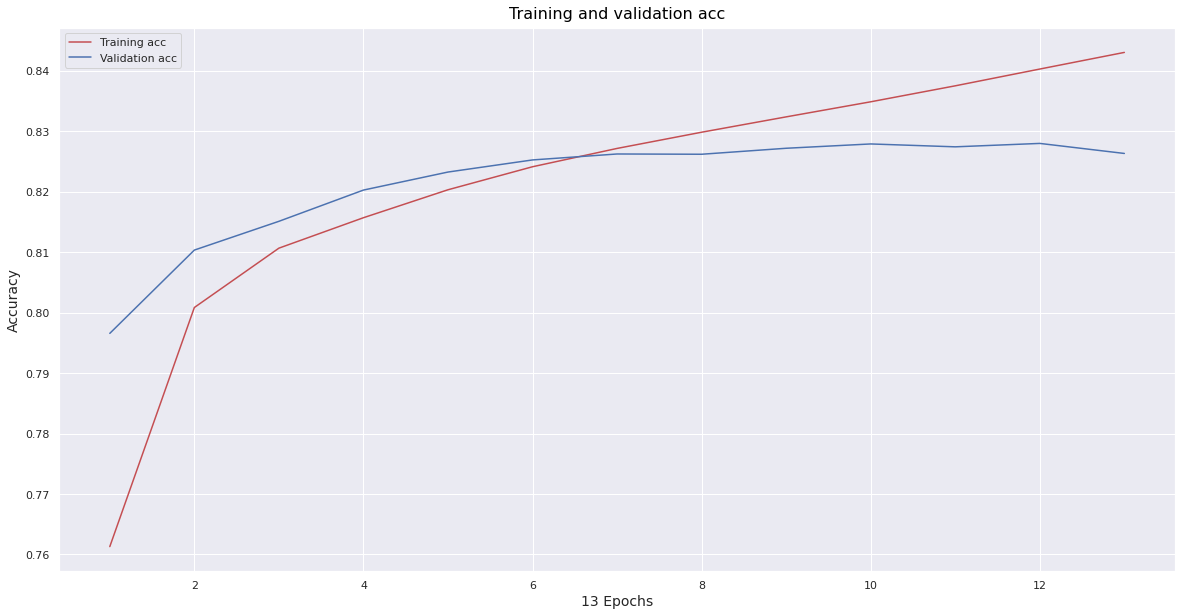

In [ ]:
plot_acc(history, filename='', save=False)

# Preparar  inferencia para o encoder e o decoder

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(EMBEEDING_DIM,))
decoder_state_input_c = Input(shape=(EMBEEDING_DIM,))
decoder_hidden_state_input = Input(shape=(TEXT_MAXLEN, EMBEEDING_DIM))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = title_word2idx[SOS]

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
            break
        else:
            sampled_token = title_idx2word[sampled_token_index]

        if(sampled_token!=EOS):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == EOS or len(decoded_sentence.split()) >= (TITLE_MAXLEN-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence.strip()

In [ ]:
def seq2title(input_seq):
    new_string = ''
    
    for i in input_seq:
        if i != 0 and i!= title_word2idx[SOS] and i != title_word2idx[EOS]:
            new_string += title_idx2word[i] + ' '
    return new_string

def seq2text(input_seq):
    new_string = ''
    
    for i in input_seq:
        if i != 0:
            new_string += text_idx2word[i] + ' '
    return new_string

# Computação das Métricas

<h2>Bleu</h2>

In [ ]:
print("Computando o Bleu para ", len(text_test), "sentenças")
print()
scores_bleu = compute_bleu(text_test, title_test, TEXT_MAXLEN, seq2title, decode_sequence)
print("Min:", round(np.min(scores_bleu), 4), '\n')
print("Média:", round(np.mean(scores_bleu), 4), '\n')
print("Max:", round(np.max(scores_bleu), 4), '\n')
print("Desvio Padrão:", round(np.std(scores_bleu), 4), '\n')
print("Variância:", round(np.var(scores_bleu), 4), '\n')
print("Coeficiente de Variação:", round(np.std(scores_bleu)/np.mean(scores_bleu) * 100, 4), '\n')
print()

Computando o Bleu para  12918 sentenças



/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg


Min: 0.0 

Média: 0.1459 

Max: 1.0 

Desvio Padrão: 0.2578 

Variância: 0.0665 

Coeficiente de Variação: 176.7036 




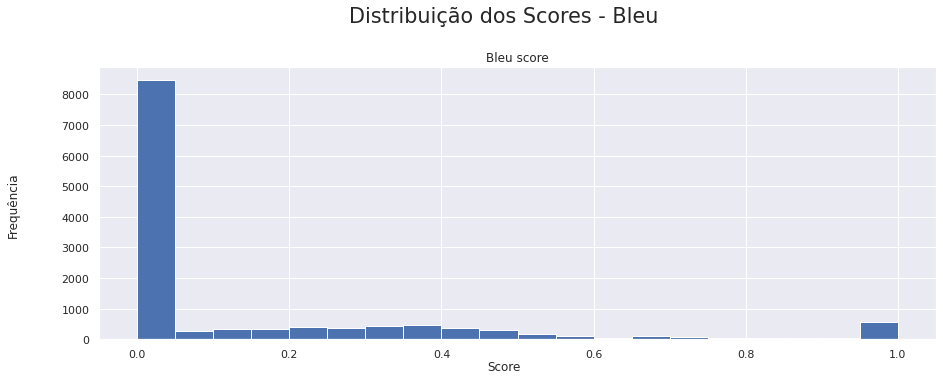

In [ ]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()

length_df = pd.DataFrame({'Bleu score':scores_bleu})
length_df.hist(bins = 20, ax=ax)

# set title and axis labels
plt.suptitle('Distribuição dos Scores - Bleu', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Score', ha='center')
fig.text(0.04, 0.5, 'Frequência', va='center', rotation='vertical')
plt.show()

<h2>Meteor</h2>

In [ ]:
print("Computando o Meteor para ", len(text_test), "sentenças")
print()
scores_meteor = compute_meteor(text_test, title_test, TEXT_MAXLEN, seq2title, decode_sequence)
print("Min:", round(np.min(scores_meteor), 4), '\n')
print("Média:", round(np.mean(scores_meteor),4), '\n')
print("Max:", round(np.max(scores_meteor), 4), '\n')
print("Desvio Padrão:", round(np.std(scores_meteor), 4), '\n')
print("Variância:", round(np.var(scores_meteor), 4), '\n')
print("Coeficiente de Variação:", round(np.std(scores_meteor)/np.mean(scores_meteor) * 100, 4), '\n')
print()

Computando o Meteor para  12918 sentenças




Min: 0.0 

Média: 0.1182 

Max: 0.9922 

Desvio Padrão: 0.2249 

Variância: 0.0506 

Coeficiente de Variação: 190.2299 




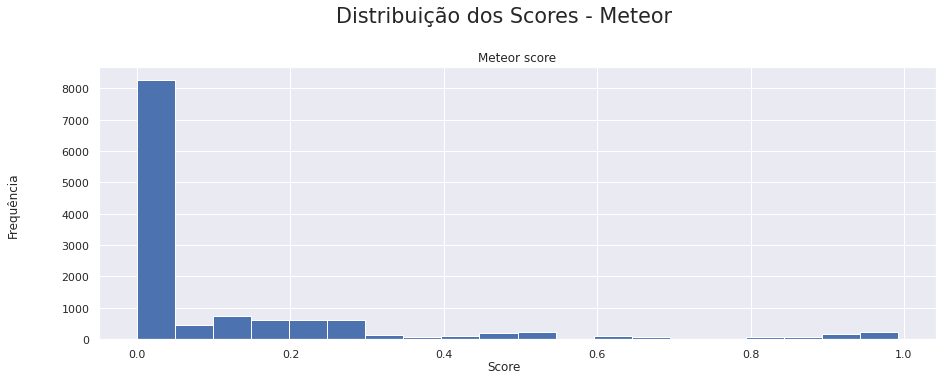

In [ ]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()

length_df = pd.DataFrame({'Meteor score':scores_meteor})
length_df.hist(bins = 20, ax=ax)

# set title and axis labels
plt.suptitle('Distribuição dos Scores - Meteor', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Score', ha='center')
fig.text(0.04, 0.5, 'Frequência', va='center', rotation='vertical')
plt.show()

# Exemplo de geração de texto com o modelo treinado usando o conjunto de testes

In [ ]:
for i in range(1000, 1100):
    print("Text Review:",seq2text(text_test[i]))
    print("Original Title Review:", seq2title(title_test[i]))
    print("Predicted Title Review:", decode_sequence(text_test[i].reshape(1, TEXT_MAXLEN)))
    print("\n")

Text Review: produto em ordem e dentro do prazo de entrega . recomendo 
Original Title Review: perfeito 
Predicted Title Review: gostei do produto


Text Review: é o melhor sistema operacional , não trava e os aplicativos são bem selecionados só top . o meu é o , já o tenho a quase quatro anos e nunca deu defeito . parabéns . 
Original Title Review: muito ótimo 
Predicted Title Review: excelente


Text Review: xxxxxxxxxxxxxxxxxxxx xxxxxxxxxxxxxxxxxxxx 
Original Title Review: gostei 
Predicted Title Review: não gostei


Text Review: amigos , este barbeador não funciona ligado a tomada justamente para evita choques elétricos , porque foi feito para ser usado na agua , muito bom , já tenho um a muitos anos , nunca deu problema . 
Original Title Review: segurança total 
Predicted Title Review: gostei


Text Review: atendeu as minhas expectativas e chegou antes do prazo recomendo 
Original Title Review: gostei 
Predicted Title Review: gostei muito do produto


Text Review: ótimo produto , d

# Para gerar um Title review use a função <i>translate</i>

In [ ]:
sentences = ['Coloque suas frases aqui', 'é ruim', 'não chegou']
result = translate(sentences, decode_sequence, text_tokenizer, TEXT_MAXLEN)

for title_review in result:
    print(title_review + '\n')

produto de qualidade

não gostei

não chegou



# Vamos salvar 200 previsões de sentenças aleatórias para avaliação

In [ ]:
text_test_inf = []
titles_pred = []

N = 200

indexes = [i for i in range(len(title_test))]
random_indexes = random.sample(indexes, N)

with tqdm(total=len(random_indexes)) as pbar:
  for i in random_indexes:
    text_test_inf.append(seq2text(text_test[i]))
    titles_pred.append(decode_sequence(text_test[i].reshape(1, TEXT_MAXLEN)))
    pbar.update(1)

text_review = np.array(text_test_inf)
pred_title_review = np.array(titles_pred)
human_score = [0] * N

df = pd.DataFrame({'Text Review' : text_review, 
                   'Predicted Title Review' : pred_title_review,
                   'Human Score': human_score})
                  
df.to_csv('bilstm_human_review.csv', index=False)